# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
#data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

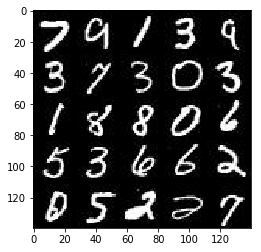

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

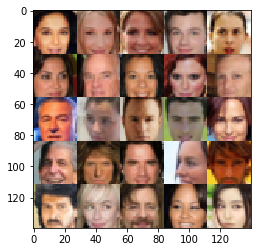

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function

    real_input_images = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels),
                                       name='real_input_images')
    input_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    
    return real_input_images, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    kernel_initializer = tf.random_normal_initializer(mean = 0, stddev = 0.02)
    alpha = 0.2    
    with tf.variable_scope('discriminator', reuse=reuse):
        # 28x28x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same', kernel_initializer=kernel_initializer)
        lrelu1 = tf.maximum(alpha * x1, x1)
        # 14x14x64
            
        x2 = tf.layers.conv2d(lrelu1, 64, 5, strides=1, padding='same', kernel_initializer=kernel_initializer)
        bn2 = tf.layers.batch_normalization(x2, training=True)
        lrelu2 = tf.maximum(alpha * bn2, bn2)
        # 14x14x64
            
        x3 = tf.layers.conv2d(lrelu2, 128, 5, strides=2, padding='same', kernel_initializer=kernel_initializer)
        bn3 = tf.layers.batch_normalization(x3, training=True)
        lrelu3 = tf.maximum(alpha * bn3, bn3)
        # 7x7x128
            
        x4 = tf.layers.conv2d(lrelu3, 128, 5, strides=1, padding='same', kernel_initializer=kernel_initializer)
        bn4 = tf.layers.batch_normalization(x4, training=True)
        lrelu4 = tf.maximum(alpha * bn4, bn4)
        # 7x7x128
    
        flatten = tf.contrib.layers.flatten(lrelu4)
        flat = tf.reshape(flatten, (-1, 7*7*128))
        logits = tf.layers.dense(flat, 1)
        output = tf.sigmoid(logits)
    
        return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    kernel_initializer = tf.random_normal_initializer(mean = 0, stddev = 0.02)
    alpha = 0.2
    with tf.variable_scope('generator', reuse=not is_train):
        x1 = tf.layers.dense(z, 7*7*256)
        x1 = tf.reshape(x1, (-1, 7, 7, 256))
        bn1 = tf.layers.batch_normalization(x1, training=is_train)
        lrelu1 = tf.maximum(alpha * bn1, bn1)
        # 7x7x256 now
        
        x2 = tf.layers.conv2d_transpose(lrelu1, 256, 5, strides=1, padding='same', kernel_initializer=kernel_initializer)
        bn2 = tf.layers.batch_normalization(x2, training=is_train)
        lrelu2 = tf.maximum(alpha * bn2, bn2)
        # 7x7x256 now
        
        x3 = tf.layers.conv2d_transpose(lrelu2, 128, 5, strides=2, padding='same', kernel_initializer=kernel_initializer)
        bn3 = tf.layers.batch_normalization(x3, training=is_train)
        lrelu3 = tf.maximum(alpha * bn3, bn3)
        # 14x14x128 now
        
        x4 = tf.layers.conv2d_transpose(lrelu3, 128, 5, strides=1, padding='same', kernel_initializer=kernel_initializer)
        bn4 = tf.layers.batch_normalization(x4, training=is_train)
        lrelu4 = tf.maximum(alpha * bn4, bn4)
        # 14x14x128 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(lrelu4, out_channel_dim, 5, strides=2, padding='same', kernel_initializer=kernel_initializer)
        # 28x28x3 now
        
        output = tf.tanh(logits)
        
        return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`


Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    image_count, image_width, image_height, image_channels = data_shape
    input_real, input_z, learn_rate = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)

    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps +=1
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Scale the images to -1:1
                batch_images *= 2
                
                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, learn_rate : learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images, learn_rate : learning_rate})
                
                if steps % 10 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    
                if steps % 100 == 0:
                    show_generator_output(sess, 25, input_z, image_channels, data_image_mode)
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.7208... Generator Loss: 0.9703
Epoch 1/2... Discriminator Loss: 1.0671... Generator Loss: 1.8227
Epoch 1/2... Discriminator Loss: 1.5492... Generator Loss: 0.4326
Epoch 1/2... Discriminator Loss: 1.5997... Generator Loss: 0.3370
Epoch 1/2... Discriminator Loss: 1.7705... Generator Loss: 4.1040
Epoch 1/2... Discriminator Loss: 0.5480... Generator Loss: 1.6268
Epoch 1/2... Discriminator Loss: 0.9383... Generator Loss: 0.9554
Epoch 1/2... Discriminator Loss: 1.1374... Generator Loss: 0.6457
Epoch 1/2... Discriminator Loss: 0.8143... Generator Loss: 0.8477
Epoch 1/2... Discriminator Loss: 0.8572... Generator Loss: 0.8372


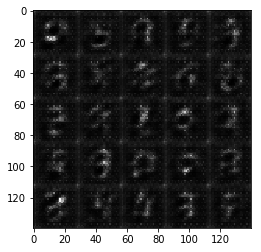

Epoch 1/2... Discriminator Loss: 0.8631... Generator Loss: 1.9218
Epoch 1/2... Discriminator Loss: 0.9028... Generator Loss: 1.0511
Epoch 1/2... Discriminator Loss: 0.9202... Generator Loss: 1.5979
Epoch 1/2... Discriminator Loss: 0.8168... Generator Loss: 1.1895
Epoch 1/2... Discriminator Loss: 0.7460... Generator Loss: 1.0413
Epoch 1/2... Discriminator Loss: 1.3767... Generator Loss: 0.3767
Epoch 1/2... Discriminator Loss: 0.9969... Generator Loss: 0.7627
Epoch 1/2... Discriminator Loss: 0.9326... Generator Loss: 1.9116
Epoch 1/2... Discriminator Loss: 1.4068... Generator Loss: 0.3557
Epoch 1/2... Discriminator Loss: 0.8376... Generator Loss: 1.9922


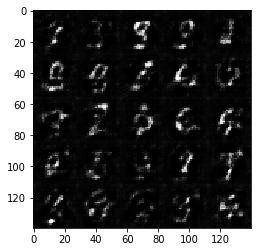

Epoch 1/2... Discriminator Loss: 0.7930... Generator Loss: 1.5610
Epoch 1/2... Discriminator Loss: 0.7611... Generator Loss: 1.0883
Epoch 1/2... Discriminator Loss: 0.7395... Generator Loss: 1.3108
Epoch 1/2... Discriminator Loss: 0.7157... Generator Loss: 1.7496
Epoch 1/2... Discriminator Loss: 1.3182... Generator Loss: 0.4375
Epoch 1/2... Discriminator Loss: 1.0201... Generator Loss: 2.1150
Epoch 1/2... Discriminator Loss: 0.6075... Generator Loss: 1.6588
Epoch 1/2... Discriminator Loss: 0.9556... Generator Loss: 0.7297
Epoch 1/2... Discriminator Loss: 0.8860... Generator Loss: 0.7162
Epoch 1/2... Discriminator Loss: 0.7685... Generator Loss: 1.5625


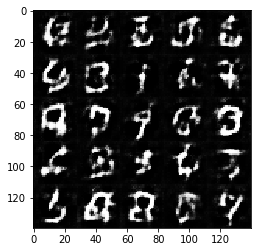

Epoch 1/2... Discriminator Loss: 0.6883... Generator Loss: 1.2569
Epoch 1/2... Discriminator Loss: 0.5768... Generator Loss: 1.5957
Epoch 1/2... Discriminator Loss: 1.2286... Generator Loss: 0.4587
Epoch 1/2... Discriminator Loss: 0.7448... Generator Loss: 0.8497
Epoch 1/2... Discriminator Loss: 1.0790... Generator Loss: 0.5916
Epoch 1/2... Discriminator Loss: 0.6197... Generator Loss: 1.4179
Epoch 1/2... Discriminator Loss: 0.9593... Generator Loss: 2.8312
Epoch 1/2... Discriminator Loss: 0.8032... Generator Loss: 1.2488
Epoch 1/2... Discriminator Loss: 1.0017... Generator Loss: 0.5991
Epoch 1/2... Discriminator Loss: 0.9941... Generator Loss: 1.2355


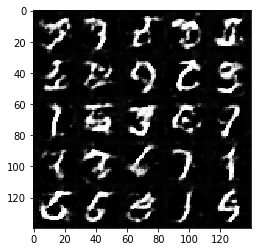

Epoch 1/2... Discriminator Loss: 0.7051... Generator Loss: 1.8149
Epoch 1/2... Discriminator Loss: 0.8290... Generator Loss: 0.8227
Epoch 1/2... Discriminator Loss: 0.8089... Generator Loss: 0.9607
Epoch 1/2... Discriminator Loss: 1.7219... Generator Loss: 3.0781
Epoch 1/2... Discriminator Loss: 0.9330... Generator Loss: 0.7912
Epoch 1/2... Discriminator Loss: 0.7558... Generator Loss: 0.9423
Epoch 1/2... Discriminator Loss: 0.7068... Generator Loss: 1.1229
Epoch 1/2... Discriminator Loss: 0.8086... Generator Loss: 0.8999
Epoch 1/2... Discriminator Loss: 0.9035... Generator Loss: 2.1824
Epoch 1/2... Discriminator Loss: 0.5759... Generator Loss: 1.2849


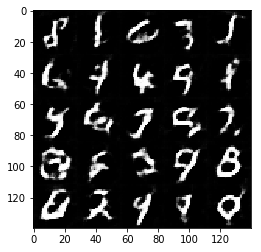

Epoch 1/2... Discriminator Loss: 0.8972... Generator Loss: 0.7459
Epoch 1/2... Discriminator Loss: 1.2973... Generator Loss: 0.8802
Epoch 1/2... Discriminator Loss: 2.0819... Generator Loss: 0.2215
Epoch 1/2... Discriminator Loss: 1.0721... Generator Loss: 0.6128
Epoch 1/2... Discriminator Loss: 1.1576... Generator Loss: 0.5622
Epoch 1/2... Discriminator Loss: 0.9729... Generator Loss: 0.7313
Epoch 1/2... Discriminator Loss: 0.7248... Generator Loss: 0.9663
Epoch 1/2... Discriminator Loss: 0.4970... Generator Loss: 1.5376
Epoch 1/2... Discriminator Loss: 6.0768... Generator Loss: 0.0052
Epoch 1/2... Discriminator Loss: 0.7424... Generator Loss: 1.2819


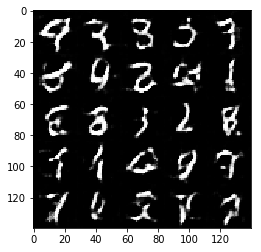

Epoch 1/2... Discriminator Loss: 0.6426... Generator Loss: 1.1902
Epoch 1/2... Discriminator Loss: 0.6474... Generator Loss: 1.0353
Epoch 1/2... Discriminator Loss: 0.7514... Generator Loss: 0.9087
Epoch 1/2... Discriminator Loss: 0.6456... Generator Loss: 1.2372
Epoch 1/2... Discriminator Loss: 0.6989... Generator Loss: 1.0649
Epoch 1/2... Discriminator Loss: 1.2076... Generator Loss: 0.5173
Epoch 1/2... Discriminator Loss: 2.3100... Generator Loss: 3.3696
Epoch 1/2... Discriminator Loss: 1.0585... Generator Loss: 0.5942
Epoch 1/2... Discriminator Loss: 0.7587... Generator Loss: 1.2300
Epoch 1/2... Discriminator Loss: 0.8232... Generator Loss: 0.9452


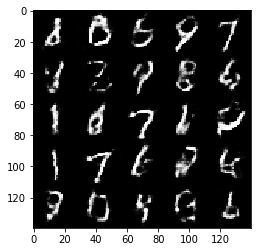

Epoch 1/2... Discriminator Loss: 0.8021... Generator Loss: 0.8633
Epoch 1/2... Discriminator Loss: 0.7830... Generator Loss: 1.0606
Epoch 1/2... Discriminator Loss: 0.9789... Generator Loss: 2.0765
Epoch 1/2... Discriminator Loss: 1.5777... Generator Loss: 3.0947
Epoch 1/2... Discriminator Loss: 0.6922... Generator Loss: 1.1842
Epoch 1/2... Discriminator Loss: 0.6731... Generator Loss: 1.0297
Epoch 1/2... Discriminator Loss: 0.8659... Generator Loss: 0.7980
Epoch 1/2... Discriminator Loss: 0.5397... Generator Loss: 1.3645
Epoch 1/2... Discriminator Loss: 0.7532... Generator Loss: 0.9616
Epoch 1/2... Discriminator Loss: 0.8411... Generator Loss: 1.0516


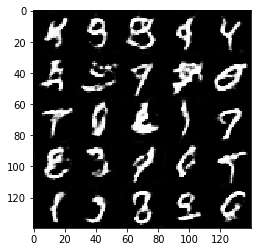

Epoch 1/2... Discriminator Loss: 0.5503... Generator Loss: 1.3396
Epoch 1/2... Discriminator Loss: 0.7431... Generator Loss: 0.8769
Epoch 1/2... Discriminator Loss: 1.0765... Generator Loss: 0.6654
Epoch 1/2... Discriminator Loss: 1.1189... Generator Loss: 2.0994
Epoch 1/2... Discriminator Loss: 1.3477... Generator Loss: 0.4486
Epoch 1/2... Discriminator Loss: 0.7193... Generator Loss: 1.4340
Epoch 1/2... Discriminator Loss: 0.5148... Generator Loss: 1.6572
Epoch 1/2... Discriminator Loss: 2.2541... Generator Loss: 3.0271
Epoch 1/2... Discriminator Loss: 0.9487... Generator Loss: 0.8837
Epoch 1/2... Discriminator Loss: 0.8213... Generator Loss: 0.8958


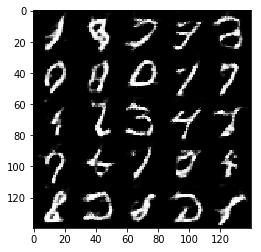

Epoch 1/2... Discriminator Loss: 0.9325... Generator Loss: 0.9857
Epoch 1/2... Discriminator Loss: 0.5610... Generator Loss: 1.4341
Epoch 1/2... Discriminator Loss: 0.5550... Generator Loss: 1.4517
Epoch 2/2... Discriminator Loss: 0.6168... Generator Loss: 1.0992
Epoch 2/2... Discriminator Loss: 0.8454... Generator Loss: 0.7461
Epoch 2/2... Discriminator Loss: 0.6398... Generator Loss: 1.8816
Epoch 2/2... Discriminator Loss: 0.9363... Generator Loss: 1.7659
Epoch 2/2... Discriminator Loss: 0.9220... Generator Loss: 0.9735
Epoch 2/2... Discriminator Loss: 1.0160... Generator Loss: 0.7349
Epoch 2/2... Discriminator Loss: 0.9952... Generator Loss: 1.1826


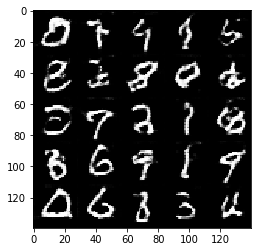

Epoch 2/2... Discriminator Loss: 0.5613... Generator Loss: 1.5397
Epoch 2/2... Discriminator Loss: 0.7829... Generator Loss: 1.2335
Epoch 2/2... Discriminator Loss: 1.5227... Generator Loss: 0.3520
Epoch 2/2... Discriminator Loss: 0.6892... Generator Loss: 1.3067
Epoch 2/2... Discriminator Loss: 1.0638... Generator Loss: 0.6100
Epoch 2/2... Discriminator Loss: 0.6259... Generator Loss: 1.1060
Epoch 2/2... Discriminator Loss: 1.7367... Generator Loss: 2.9956
Epoch 2/2... Discriminator Loss: 0.8942... Generator Loss: 0.7990
Epoch 2/2... Discriminator Loss: 0.7929... Generator Loss: 1.0191
Epoch 2/2... Discriminator Loss: 0.7556... Generator Loss: 1.0053


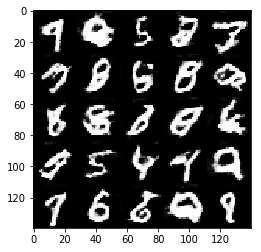

Epoch 2/2... Discriminator Loss: 0.7408... Generator Loss: 1.1378
Epoch 2/2... Discriminator Loss: 0.8744... Generator Loss: 0.8015
Epoch 2/2... Discriminator Loss: 0.9317... Generator Loss: 0.7100
Epoch 2/2... Discriminator Loss: 2.3337... Generator Loss: 0.1718
Epoch 2/2... Discriminator Loss: 0.8600... Generator Loss: 1.0840
Epoch 2/2... Discriminator Loss: 0.6535... Generator Loss: 1.6633
Epoch 2/2... Discriminator Loss: 0.8874... Generator Loss: 0.7696
Epoch 2/2... Discriminator Loss: 0.8930... Generator Loss: 0.7512
Epoch 2/2... Discriminator Loss: 1.1765... Generator Loss: 0.5271
Epoch 2/2... Discriminator Loss: 0.8491... Generator Loss: 1.8873


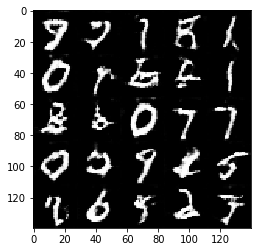

Epoch 2/2... Discriminator Loss: 1.1651... Generator Loss: 2.4169
Epoch 2/2... Discriminator Loss: 0.7834... Generator Loss: 1.0701
Epoch 2/2... Discriminator Loss: 0.8942... Generator Loss: 1.0565
Epoch 2/2... Discriminator Loss: 0.9827... Generator Loss: 0.9158
Epoch 2/2... Discriminator Loss: 0.5497... Generator Loss: 2.3510
Epoch 2/2... Discriminator Loss: 1.0996... Generator Loss: 0.6534
Epoch 2/2... Discriminator Loss: 0.5042... Generator Loss: 1.7780
Epoch 2/2... Discriminator Loss: 0.9617... Generator Loss: 0.7347
Epoch 2/2... Discriminator Loss: 1.3432... Generator Loss: 0.5299
Epoch 2/2... Discriminator Loss: 0.9724... Generator Loss: 0.9668


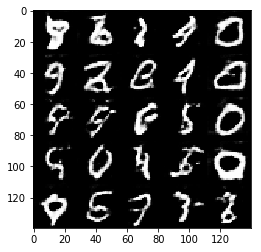

Epoch 2/2... Discriminator Loss: 1.1130... Generator Loss: 0.6360
Epoch 2/2... Discriminator Loss: 0.5783... Generator Loss: 1.9986
Epoch 2/2... Discriminator Loss: 0.7520... Generator Loss: 1.0397
Epoch 2/2... Discriminator Loss: 0.6997... Generator Loss: 1.0842
Epoch 2/2... Discriminator Loss: 0.6692... Generator Loss: 2.5373
Epoch 2/2... Discriminator Loss: 0.7571... Generator Loss: 1.3646
Epoch 2/2... Discriminator Loss: 0.9484... Generator Loss: 1.5241
Epoch 2/2... Discriminator Loss: 0.8297... Generator Loss: 1.3230
Epoch 2/2... Discriminator Loss: 1.0813... Generator Loss: 0.6268
Epoch 2/2... Discriminator Loss: 0.6978... Generator Loss: 1.5500


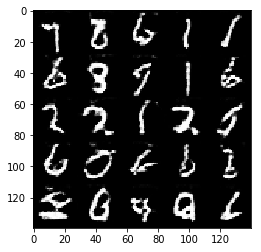

Epoch 2/2... Discriminator Loss: 0.5592... Generator Loss: 1.3143
Epoch 2/2... Discriminator Loss: 0.8450... Generator Loss: 2.3319
Epoch 2/2... Discriminator Loss: 0.8647... Generator Loss: 0.8422
Epoch 2/2... Discriminator Loss: 0.5278... Generator Loss: 1.6407
Epoch 2/2... Discriminator Loss: 0.4426... Generator Loss: 1.6000
Epoch 2/2... Discriminator Loss: 0.6972... Generator Loss: 1.4695
Epoch 2/2... Discriminator Loss: 0.8275... Generator Loss: 0.9813
Epoch 2/2... Discriminator Loss: 0.6350... Generator Loss: 1.1478
Epoch 2/2... Discriminator Loss: 1.0190... Generator Loss: 0.6648
Epoch 2/2... Discriminator Loss: 0.6017... Generator Loss: 1.6612


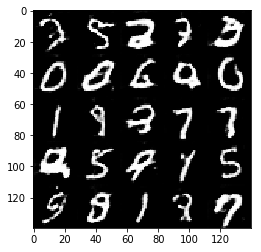

Epoch 2/2... Discriminator Loss: 0.7457... Generator Loss: 0.9185
Epoch 2/2... Discriminator Loss: 0.9667... Generator Loss: 0.6813
Epoch 2/2... Discriminator Loss: 0.9174... Generator Loss: 0.8645
Epoch 2/2... Discriminator Loss: 0.9139... Generator Loss: 0.8804
Epoch 2/2... Discriminator Loss: 0.7296... Generator Loss: 1.5156
Epoch 2/2... Discriminator Loss: 1.2690... Generator Loss: 0.5066
Epoch 2/2... Discriminator Loss: 1.7161... Generator Loss: 0.3539
Epoch 2/2... Discriminator Loss: 0.7651... Generator Loss: 0.9246
Epoch 2/2... Discriminator Loss: 0.4660... Generator Loss: 1.6358
Epoch 2/2... Discriminator Loss: 0.5909... Generator Loss: 1.2597


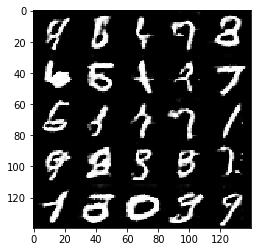

Epoch 2/2... Discriminator Loss: 1.1809... Generator Loss: 3.6376
Epoch 2/2... Discriminator Loss: 0.8581... Generator Loss: 1.0204
Epoch 2/2... Discriminator Loss: 0.7706... Generator Loss: 1.1425
Epoch 2/2... Discriminator Loss: 0.6246... Generator Loss: 1.6828
Epoch 2/2... Discriminator Loss: 0.6277... Generator Loss: 1.9117
Epoch 2/2... Discriminator Loss: 0.6003... Generator Loss: 1.1005
Epoch 2/2... Discriminator Loss: 0.8669... Generator Loss: 0.7837
Epoch 2/2... Discriminator Loss: 0.8456... Generator Loss: 2.1771
Epoch 2/2... Discriminator Loss: 1.0509... Generator Loss: 0.7860
Epoch 2/2... Discriminator Loss: 0.6356... Generator Loss: 2.1063


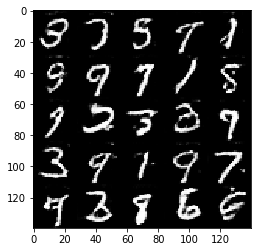

Epoch 2/2... Discriminator Loss: 0.6117... Generator Loss: 1.3839
Epoch 2/2... Discriminator Loss: 0.4591... Generator Loss: 1.5991
Epoch 2/2... Discriminator Loss: 1.2021... Generator Loss: 0.5240
Epoch 2/2... Discriminator Loss: 1.1888... Generator Loss: 0.5314
Epoch 2/2... Discriminator Loss: 1.0216... Generator Loss: 0.8390
Epoch 2/2... Discriminator Loss: 0.4427... Generator Loss: 2.5546
Epoch 2/2... Discriminator Loss: 0.3786... Generator Loss: 2.4494
Epoch 2/2... Discriminator Loss: 0.6510... Generator Loss: 1.0576
Epoch 2/2... Discriminator Loss: 0.8691... Generator Loss: 0.7368
Epoch 2/2... Discriminator Loss: 1.0839... Generator Loss: 0.6508


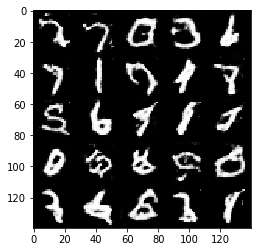

Epoch 2/2... Discriminator Loss: 0.9356... Generator Loss: 2.8838
Epoch 2/2... Discriminator Loss: 0.7250... Generator Loss: 1.3155
Epoch 2/2... Discriminator Loss: 0.6670... Generator Loss: 1.2582
Epoch 2/2... Discriminator Loss: 0.6485... Generator Loss: 1.3238
Epoch 2/2... Discriminator Loss: 0.6420... Generator Loss: 1.0343
Epoch 2/2... Discriminator Loss: 1.6683... Generator Loss: 0.3060
Epoch 2/2... Discriminator Loss: 0.5394... Generator Loss: 1.3377


In [ ]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.2686... Generator Loss: 0.6033
Epoch 1/1... Discriminator Loss: 0.6426... Generator Loss: 4.4576
Epoch 1/1... Discriminator Loss: 1.1182... Generator Loss: 0.8826
Epoch 1/1... Discriminator Loss: 1.4164... Generator Loss: 0.9509
Epoch 1/1... Discriminator Loss: 2.7319... Generator Loss: 0.1525
Epoch 1/1... Discriminator Loss: 0.6182... Generator Loss: 2.0631
Epoch 1/1... Discriminator Loss: 1.5884... Generator Loss: 0.4386
Epoch 1/1... Discriminator Loss: 0.8159... Generator Loss: 3.7981
Epoch 1/1... Discriminator Loss: 0.4832... Generator Loss: 1.6638
Epoch 1/1... Discriminator Loss: 0.4926... Generator Loss: 1.6458


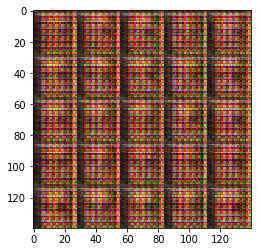

Epoch 1/1... Discriminator Loss: 0.4751... Generator Loss: 2.2093
Epoch 1/1... Discriminator Loss: 0.8141... Generator Loss: 1.1032
Epoch 1/1... Discriminator Loss: 0.5103... Generator Loss: 2.2915
Epoch 1/1... Discriminator Loss: 0.6072... Generator Loss: 1.2944
Epoch 1/1... Discriminator Loss: 0.4710... Generator Loss: 1.9281
Epoch 1/1... Discriminator Loss: 1.4946... Generator Loss: 0.3887
Epoch 1/1... Discriminator Loss: 2.0230... Generator Loss: 0.2600
Epoch 1/1... Discriminator Loss: 1.0701... Generator Loss: 1.1090
Epoch 1/1... Discriminator Loss: 1.2982... Generator Loss: 2.1294
Epoch 1/1... Discriminator Loss: 1.0337... Generator Loss: 0.8119


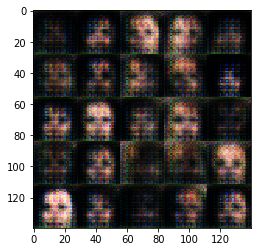

Epoch 1/1... Discriminator Loss: 1.1093... Generator Loss: 0.8193
Epoch 1/1... Discriminator Loss: 1.6724... Generator Loss: 0.4160
Epoch 1/1... Discriminator Loss: 1.0655... Generator Loss: 0.9516
Epoch 1/1... Discriminator Loss: 0.6607... Generator Loss: 1.2734
Epoch 1/1... Discriminator Loss: 0.6929... Generator Loss: 1.3096
Epoch 1/1... Discriminator Loss: 2.0329... Generator Loss: 0.3083
Epoch 1/1... Discriminator Loss: 0.8129... Generator Loss: 1.1694
Epoch 1/1... Discriminator Loss: 0.8218... Generator Loss: 1.3814
Epoch 1/1... Discriminator Loss: 1.2074... Generator Loss: 0.8891
Epoch 1/1... Discriminator Loss: 1.3368... Generator Loss: 1.5579


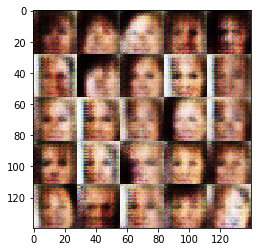

Epoch 1/1... Discriminator Loss: 0.8031... Generator Loss: 1.1212
Epoch 1/1... Discriminator Loss: 1.1487... Generator Loss: 1.0971
Epoch 1/1... Discriminator Loss: 0.8491... Generator Loss: 1.2184
Epoch 1/1... Discriminator Loss: 1.1157... Generator Loss: 0.9797
Epoch 1/1... Discriminator Loss: 1.0043... Generator Loss: 1.2028
Epoch 1/1... Discriminator Loss: 1.2487... Generator Loss: 0.9538
Epoch 1/1... Discriminator Loss: 1.1447... Generator Loss: 0.7828
Epoch 1/1... Discriminator Loss: 0.9987... Generator Loss: 1.4613
Epoch 1/1... Discriminator Loss: 1.0414... Generator Loss: 1.6340
Epoch 1/1... Discriminator Loss: 1.0130... Generator Loss: 0.7673


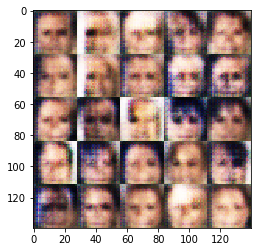

Epoch 1/1... Discriminator Loss: 0.9089... Generator Loss: 1.3554
Epoch 1/1... Discriminator Loss: 0.8998... Generator Loss: 0.8276
Epoch 1/1... Discriminator Loss: 1.1239... Generator Loss: 0.7001
Epoch 1/1... Discriminator Loss: 0.9071... Generator Loss: 1.5057
Epoch 1/1... Discriminator Loss: 0.6685... Generator Loss: 1.2748
Epoch 1/1... Discriminator Loss: 1.1510... Generator Loss: 1.0883
Epoch 1/1... Discriminator Loss: 1.2729... Generator Loss: 1.2874
Epoch 1/1... Discriminator Loss: 1.1732... Generator Loss: 1.1426
Epoch 1/1... Discriminator Loss: 1.1884... Generator Loss: 0.8781
Epoch 1/1... Discriminator Loss: 1.3960... Generator Loss: 0.5620


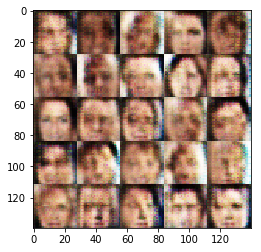

Epoch 1/1... Discriminator Loss: 0.8259... Generator Loss: 1.2056
Epoch 1/1... Discriminator Loss: 1.6723... Generator Loss: 0.3523
Epoch 1/1... Discriminator Loss: 0.7949... Generator Loss: 1.1661
Epoch 1/1... Discriminator Loss: 0.9039... Generator Loss: 1.0223
Epoch 1/1... Discriminator Loss: 0.5920... Generator Loss: 1.3191
Epoch 1/1... Discriminator Loss: 1.1658... Generator Loss: 1.0741
Epoch 1/1... Discriminator Loss: 0.9251... Generator Loss: 1.5777
Epoch 1/1... Discriminator Loss: 1.0178... Generator Loss: 1.0115
Epoch 1/1... Discriminator Loss: 0.9098... Generator Loss: 0.9930
Epoch 1/1... Discriminator Loss: 1.0360... Generator Loss: 0.9196


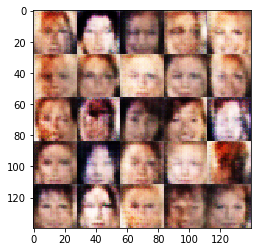

Epoch 1/1... Discriminator Loss: 0.9716... Generator Loss: 1.3384
Epoch 1/1... Discriminator Loss: 0.9403... Generator Loss: 0.8395
Epoch 1/1... Discriminator Loss: 1.4646... Generator Loss: 0.3859
Epoch 1/1... Discriminator Loss: 1.6941... Generator Loss: 0.3285
Epoch 1/1... Discriminator Loss: 0.9844... Generator Loss: 1.2614
Epoch 1/1... Discriminator Loss: 1.2593... Generator Loss: 1.3049
Epoch 1/1... Discriminator Loss: 1.2595... Generator Loss: 0.4751
Epoch 1/1... Discriminator Loss: 1.3885... Generator Loss: 0.4631
Epoch 1/1... Discriminator Loss: 1.3082... Generator Loss: 0.5177
Epoch 1/1... Discriminator Loss: 0.8821... Generator Loss: 1.1438


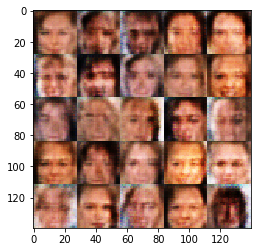

Epoch 1/1... Discriminator Loss: 1.0023... Generator Loss: 1.1492
Epoch 1/1... Discriminator Loss: 1.2342... Generator Loss: 0.8955
Epoch 1/1... Discriminator Loss: 1.1261... Generator Loss: 1.2087
Epoch 1/1... Discriminator Loss: 1.2826... Generator Loss: 0.5252
Epoch 1/1... Discriminator Loss: 1.0210... Generator Loss: 0.8117
Epoch 1/1... Discriminator Loss: 1.5052... Generator Loss: 0.8553
Epoch 1/1... Discriminator Loss: 1.1542... Generator Loss: 0.7646
Epoch 1/1... Discriminator Loss: 0.9898... Generator Loss: 1.0610
Epoch 1/1... Discriminator Loss: 1.2606... Generator Loss: 1.2677
Epoch 1/1... Discriminator Loss: 1.1194... Generator Loss: 0.9251


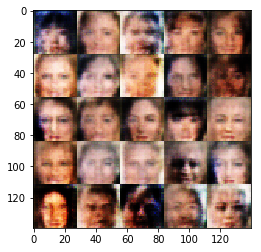

Epoch 1/1... Discriminator Loss: 1.3887... Generator Loss: 0.5766
Epoch 1/1... Discriminator Loss: 1.1692... Generator Loss: 0.9003
Epoch 1/1... Discriminator Loss: 1.2883... Generator Loss: 1.1072
Epoch 1/1... Discriminator Loss: 1.3851... Generator Loss: 0.7059
Epoch 1/1... Discriminator Loss: 1.0756... Generator Loss: 1.0993
Epoch 1/1... Discriminator Loss: 1.3581... Generator Loss: 1.3823
Epoch 1/1... Discriminator Loss: 1.2608... Generator Loss: 0.9947
Epoch 1/1... Discriminator Loss: 1.1150... Generator Loss: 0.9294
Epoch 1/1... Discriminator Loss: 1.2274... Generator Loss: 0.8531
Epoch 1/1... Discriminator Loss: 0.9139... Generator Loss: 1.1562


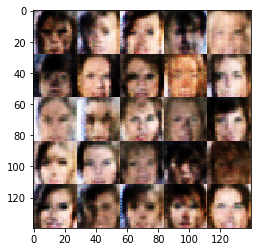

Epoch 1/1... Discriminator Loss: 1.3815... Generator Loss: 0.7645
Epoch 1/1... Discriminator Loss: 1.2300... Generator Loss: 0.8976
Epoch 1/1... Discriminator Loss: 1.3025... Generator Loss: 0.8545
Epoch 1/1... Discriminator Loss: 1.3698... Generator Loss: 0.5787
Epoch 1/1... Discriminator Loss: 1.6030... Generator Loss: 0.3870
Epoch 1/1... Discriminator Loss: 1.1044... Generator Loss: 0.7088
Epoch 1/1... Discriminator Loss: 0.9817... Generator Loss: 0.9969
Epoch 1/1... Discriminator Loss: 1.1189... Generator Loss: 1.0136
Epoch 1/1... Discriminator Loss: 0.8488... Generator Loss: 1.4301
Epoch 1/1... Discriminator Loss: 1.2336... Generator Loss: 0.5583


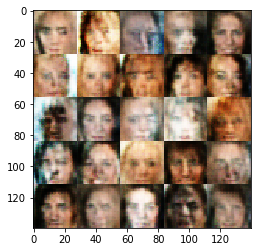

Epoch 1/1... Discriminator Loss: 1.1535... Generator Loss: 0.9122
Epoch 1/1... Discriminator Loss: 1.2012... Generator Loss: 0.7238
Epoch 1/1... Discriminator Loss: 1.2044... Generator Loss: 0.9724
Epoch 1/1... Discriminator Loss: 1.6261... Generator Loss: 0.3804
Epoch 1/1... Discriminator Loss: 1.1292... Generator Loss: 0.7005
Epoch 1/1... Discriminator Loss: 0.8924... Generator Loss: 1.0630
Epoch 1/1... Discriminator Loss: 1.0889... Generator Loss: 1.1523
Epoch 1/1... Discriminator Loss: 1.8450... Generator Loss: 0.3309
Epoch 1/1... Discriminator Loss: 1.6098... Generator Loss: 0.4981
Epoch 1/1... Discriminator Loss: 1.0639... Generator Loss: 0.7552


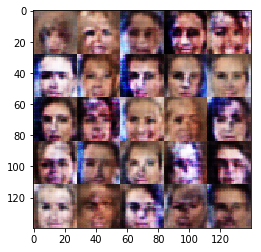

Epoch 1/1... Discriminator Loss: 1.2336... Generator Loss: 1.4766
Epoch 1/1... Discriminator Loss: 0.9432... Generator Loss: 1.1693
Epoch 1/1... Discriminator Loss: 1.1474... Generator Loss: 1.1533
Epoch 1/1... Discriminator Loss: 1.2209... Generator Loss: 0.7369
Epoch 1/1... Discriminator Loss: 1.1496... Generator Loss: 0.7667
Epoch 1/1... Discriminator Loss: 1.2250... Generator Loss: 1.0307
Epoch 1/1... Discriminator Loss: 1.2294... Generator Loss: 0.5745
Epoch 1/1... Discriminator Loss: 1.4437... Generator Loss: 0.9059
Epoch 1/1... Discriminator Loss: 1.2562... Generator Loss: 0.8421
Epoch 1/1... Discriminator Loss: 1.0162... Generator Loss: 1.1085


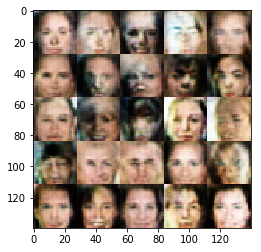

Epoch 1/1... Discriminator Loss: 1.0951... Generator Loss: 0.8252
Epoch 1/1... Discriminator Loss: 1.2135... Generator Loss: 0.6897
Epoch 1/1... Discriminator Loss: 1.0100... Generator Loss: 0.7366
Epoch 1/1... Discriminator Loss: 1.1071... Generator Loss: 0.6130
Epoch 1/1... Discriminator Loss: 1.1186... Generator Loss: 0.9725
Epoch 1/1... Discriminator Loss: 0.9513... Generator Loss: 0.9176
Epoch 1/1... Discriminator Loss: 1.1924... Generator Loss: 0.8627
Epoch 1/1... Discriminator Loss: 0.9160... Generator Loss: 0.9247
Epoch 1/1... Discriminator Loss: 1.3252... Generator Loss: 0.5149
Epoch 1/1... Discriminator Loss: 1.1970... Generator Loss: 0.6914


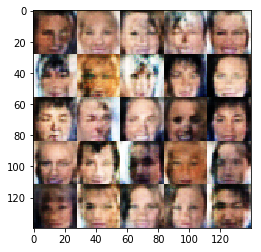

Epoch 1/1... Discriminator Loss: 1.1143... Generator Loss: 0.7816
Epoch 1/1... Discriminator Loss: 1.0788... Generator Loss: 1.0772
Epoch 1/1... Discriminator Loss: 1.0759... Generator Loss: 0.8936
Epoch 1/1... Discriminator Loss: 1.1464... Generator Loss: 0.8844
Epoch 1/1... Discriminator Loss: 1.3404... Generator Loss: 0.4983
Epoch 1/1... Discriminator Loss: 1.1399... Generator Loss: 0.7782
Epoch 1/1... Discriminator Loss: 1.0383... Generator Loss: 1.5070
Epoch 1/1... Discriminator Loss: 0.9439... Generator Loss: 0.8562
Epoch 1/1... Discriminator Loss: 1.0852... Generator Loss: 0.6749
Epoch 1/1... Discriminator Loss: 1.1384... Generator Loss: 0.6718


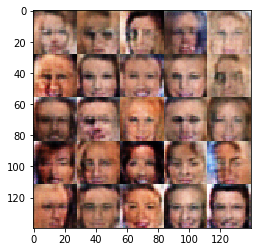

Epoch 1/1... Discriminator Loss: 1.1595... Generator Loss: 0.6083
Epoch 1/1... Discriminator Loss: 1.0598... Generator Loss: 0.8816
Epoch 1/1... Discriminator Loss: 1.1862... Generator Loss: 1.2030
Epoch 1/1... Discriminator Loss: 1.2694... Generator Loss: 0.5915
Epoch 1/1... Discriminator Loss: 1.1672... Generator Loss: 0.6160
Epoch 1/1... Discriminator Loss: 1.5531... Generator Loss: 0.4338
Epoch 1/1... Discriminator Loss: 1.3730... Generator Loss: 0.4944
Epoch 1/1... Discriminator Loss: 1.5282... Generator Loss: 0.4154
Epoch 1/1... Discriminator Loss: 1.1572... Generator Loss: 0.9716
Epoch 1/1... Discriminator Loss: 0.9423... Generator Loss: 0.8743


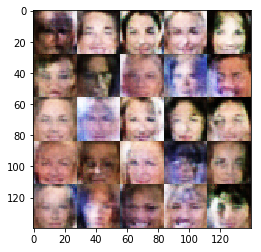

Epoch 1/1... Discriminator Loss: 0.8699... Generator Loss: 1.2686
Epoch 1/1... Discriminator Loss: 1.2938... Generator Loss: 0.9162
Epoch 1/1... Discriminator Loss: 1.3431... Generator Loss: 1.3459
Epoch 1/1... Discriminator Loss: 1.1898... Generator Loss: 1.0918
Epoch 1/1... Discriminator Loss: 1.6005... Generator Loss: 0.3449
Epoch 1/1... Discriminator Loss: 1.2657... Generator Loss: 0.5066
Epoch 1/1... Discriminator Loss: 1.2534... Generator Loss: 0.9083
Epoch 1/1... Discriminator Loss: 1.3113... Generator Loss: 0.5972
Epoch 1/1... Discriminator Loss: 1.0038... Generator Loss: 0.7841
Epoch 1/1... Discriminator Loss: 1.0359... Generator Loss: 0.7008


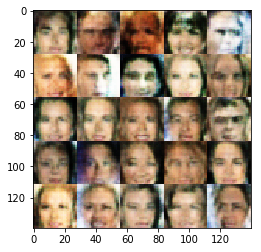

Epoch 1/1... Discriminator Loss: 1.0115... Generator Loss: 1.2396
Epoch 1/1... Discriminator Loss: 1.5310... Generator Loss: 0.6013
Epoch 1/1... Discriminator Loss: 1.2324... Generator Loss: 0.5861
Epoch 1/1... Discriminator Loss: 1.3641... Generator Loss: 0.9807
Epoch 1/1... Discriminator Loss: 1.2153... Generator Loss: 1.0734
Epoch 1/1... Discriminator Loss: 1.4427... Generator Loss: 0.4309
Epoch 1/1... Discriminator Loss: 1.0550... Generator Loss: 1.1030
Epoch 1/1... Discriminator Loss: 1.2378... Generator Loss: 0.6798
Epoch 1/1... Discriminator Loss: 1.2584... Generator Loss: 0.6009
Epoch 1/1... Discriminator Loss: 1.2611... Generator Loss: 0.6903


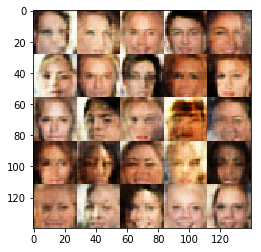

Epoch 1/1... Discriminator Loss: 1.0641... Generator Loss: 0.7526
Epoch 1/1... Discriminator Loss: 1.1443... Generator Loss: 0.7120
Epoch 1/1... Discriminator Loss: 0.9514... Generator Loss: 1.2799
Epoch 1/1... Discriminator Loss: 0.8267... Generator Loss: 1.0858
Epoch 1/1... Discriminator Loss: 1.0226... Generator Loss: 0.8448
Epoch 1/1... Discriminator Loss: 1.1338... Generator Loss: 0.9455
Epoch 1/1... Discriminator Loss: 1.0558... Generator Loss: 0.9979
Epoch 1/1... Discriminator Loss: 1.0720... Generator Loss: 1.1113
Epoch 1/1... Discriminator Loss: 1.3097... Generator Loss: 0.4646
Epoch 1/1... Discriminator Loss: 1.0348... Generator Loss: 1.0920


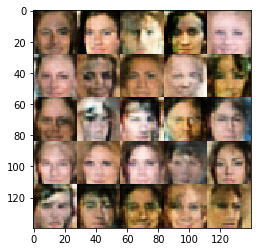

Epoch 1/1... Discriminator Loss: 0.9336... Generator Loss: 0.9114
Epoch 1/1... Discriminator Loss: 0.9868... Generator Loss: 1.0651
Epoch 1/1... Discriminator Loss: 1.3430... Generator Loss: 1.9108
Epoch 1/1... Discriminator Loss: 1.1919... Generator Loss: 0.6672
Epoch 1/1... Discriminator Loss: 1.0310... Generator Loss: 1.1201
Epoch 1/1... Discriminator Loss: 1.2125... Generator Loss: 0.8885
Epoch 1/1... Discriminator Loss: 1.0957... Generator Loss: 0.6551
Epoch 1/1... Discriminator Loss: 1.2952... Generator Loss: 0.7637
Epoch 1/1... Discriminator Loss: 1.1151... Generator Loss: 0.8790
Epoch 1/1... Discriminator Loss: 1.6235... Generator Loss: 0.5928


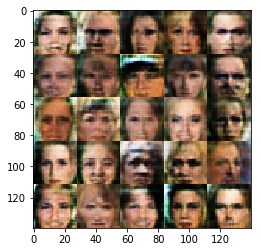

Epoch 1/1... Discriminator Loss: 1.0594... Generator Loss: 0.9854
Epoch 1/1... Discriminator Loss: 1.2114... Generator Loss: 0.8103
Epoch 1/1... Discriminator Loss: 1.1689... Generator Loss: 0.7289
Epoch 1/1... Discriminator Loss: 0.9770... Generator Loss: 1.0016
Epoch 1/1... Discriminator Loss: 1.0320... Generator Loss: 1.0416
Epoch 1/1... Discriminator Loss: 1.2302... Generator Loss: 0.6002
Epoch 1/1... Discriminator Loss: 1.1452... Generator Loss: 0.7263
Epoch 1/1... Discriminator Loss: 0.9314... Generator Loss: 1.0749
Epoch 1/1... Discriminator Loss: 1.7285... Generator Loss: 1.4727
Epoch 1/1... Discriminator Loss: 1.6779... Generator Loss: 0.3003


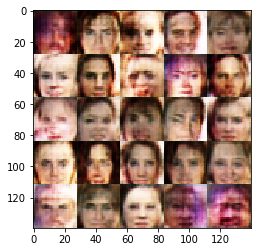

Epoch 1/1... Discriminator Loss: 0.9444... Generator Loss: 0.9716
Epoch 1/1... Discriminator Loss: 1.3572... Generator Loss: 0.5506
Epoch 1/1... Discriminator Loss: 0.9508... Generator Loss: 1.1246
Epoch 1/1... Discriminator Loss: 1.3862... Generator Loss: 0.8834
Epoch 1/1... Discriminator Loss: 1.1068... Generator Loss: 0.7484
Epoch 1/1... Discriminator Loss: 0.8194... Generator Loss: 0.9552
Epoch 1/1... Discriminator Loss: 0.9625... Generator Loss: 1.0919
Epoch 1/1... Discriminator Loss: 0.9790... Generator Loss: 1.0996
Epoch 1/1... Discriminator Loss: 1.1724... Generator Loss: 0.9747
Epoch 1/1... Discriminator Loss: 1.1078... Generator Loss: 1.5064


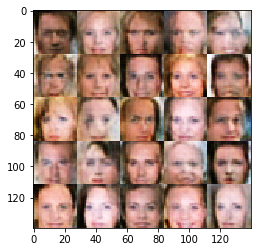

Epoch 1/1... Discriminator Loss: 1.0892... Generator Loss: 0.9254
Epoch 1/1... Discriminator Loss: 1.1164... Generator Loss: 1.0910
Epoch 1/1... Discriminator Loss: 1.0372... Generator Loss: 1.0109
Epoch 1/1... Discriminator Loss: 1.1747... Generator Loss: 0.9138
Epoch 1/1... Discriminator Loss: 1.3684... Generator Loss: 1.2635
Epoch 1/1... Discriminator Loss: 1.1601... Generator Loss: 0.6078
Epoch 1/1... Discriminator Loss: 1.1094... Generator Loss: 0.8305
Epoch 1/1... Discriminator Loss: 1.1861... Generator Loss: 0.7733
Epoch 1/1... Discriminator Loss: 1.2574... Generator Loss: 0.8255
Epoch 1/1... Discriminator Loss: 1.0710... Generator Loss: 0.7911


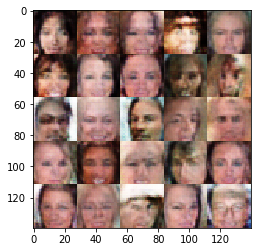

Epoch 1/1... Discriminator Loss: 1.1950... Generator Loss: 0.5829
Epoch 1/1... Discriminator Loss: 0.9878... Generator Loss: 0.7336
Epoch 1/1... Discriminator Loss: 1.1216... Generator Loss: 1.1290
Epoch 1/1... Discriminator Loss: 1.1566... Generator Loss: 0.6543
Epoch 1/1... Discriminator Loss: 1.3727... Generator Loss: 0.4534
Epoch 1/1... Discriminator Loss: 0.9983... Generator Loss: 0.7581
Epoch 1/1... Discriminator Loss: 1.2439... Generator Loss: 1.1931
Epoch 1/1... Discriminator Loss: 1.5877... Generator Loss: 0.3496
Epoch 1/1... Discriminator Loss: 0.8964... Generator Loss: 0.9661
Epoch 1/1... Discriminator Loss: 1.4612... Generator Loss: 0.6369


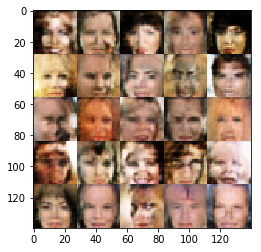

Epoch 1/1... Discriminator Loss: 1.0772... Generator Loss: 0.8549
Epoch 1/1... Discriminator Loss: 1.0192... Generator Loss: 1.0663
Epoch 1/1... Discriminator Loss: 1.0324... Generator Loss: 1.3010
Epoch 1/1... Discriminator Loss: 1.2007... Generator Loss: 0.7239
Epoch 1/1... Discriminator Loss: 1.1299... Generator Loss: 0.9344
Epoch 1/1... Discriminator Loss: 1.1940... Generator Loss: 0.9738
Epoch 1/1... Discriminator Loss: 1.1860... Generator Loss: 0.7407
Epoch 1/1... Discriminator Loss: 1.0594... Generator Loss: 0.7428
Epoch 1/1... Discriminator Loss: 0.9761... Generator Loss: 1.1298
Epoch 1/1... Discriminator Loss: 1.4696... Generator Loss: 0.4325


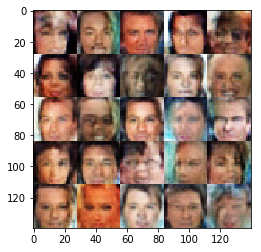

Epoch 1/1... Discriminator Loss: 1.2160... Generator Loss: 0.7991
Epoch 1/1... Discriminator Loss: 1.0308... Generator Loss: 0.8596
Epoch 1/1... Discriminator Loss: 1.4590... Generator Loss: 0.9294
Epoch 1/1... Discriminator Loss: 1.1092... Generator Loss: 0.8023
Epoch 1/1... Discriminator Loss: 1.3062... Generator Loss: 0.5661
Epoch 1/1... Discriminator Loss: 1.0681... Generator Loss: 0.9956
Epoch 1/1... Discriminator Loss: 1.3152... Generator Loss: 0.5443
Epoch 1/1... Discriminator Loss: 1.1413... Generator Loss: 0.6986
Epoch 1/1... Discriminator Loss: 0.9733... Generator Loss: 0.8433
Epoch 1/1... Discriminator Loss: 1.0391... Generator Loss: 1.2326


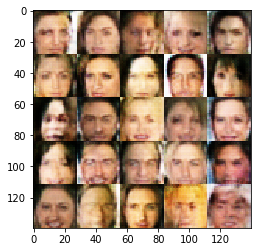

Epoch 1/1... Discriminator Loss: 1.1444... Generator Loss: 0.6772
Epoch 1/1... Discriminator Loss: 1.4792... Generator Loss: 0.4219
Epoch 1/1... Discriminator Loss: 1.3899... Generator Loss: 0.5405
Epoch 1/1... Discriminator Loss: 1.2037... Generator Loss: 0.6100
Epoch 1/1... Discriminator Loss: 1.1641... Generator Loss: 0.9769
Epoch 1/1... Discriminator Loss: 1.0866... Generator Loss: 0.8759
Epoch 1/1... Discriminator Loss: 1.1070... Generator Loss: 0.9796
Epoch 1/1... Discriminator Loss: 1.2154... Generator Loss: 1.0302
Epoch 1/1... Discriminator Loss: 1.3747... Generator Loss: 0.8640
Epoch 1/1... Discriminator Loss: 0.8611... Generator Loss: 1.0973


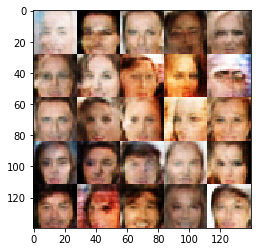

Epoch 1/1... Discriminator Loss: 1.1116... Generator Loss: 0.8150
Epoch 1/1... Discriminator Loss: 1.3398... Generator Loss: 0.7135
Epoch 1/1... Discriminator Loss: 1.7341... Generator Loss: 1.2840
Epoch 1/1... Discriminator Loss: 1.1950... Generator Loss: 0.6173
Epoch 1/1... Discriminator Loss: 1.1737... Generator Loss: 0.7073
Epoch 1/1... Discriminator Loss: 1.1331... Generator Loss: 0.8076
Epoch 1/1... Discriminator Loss: 0.9650... Generator Loss: 1.0654
Epoch 1/1... Discriminator Loss: 1.2604... Generator Loss: 0.7769
Epoch 1/1... Discriminator Loss: 0.9735... Generator Loss: 0.9385
Epoch 1/1... Discriminator Loss: 1.3392... Generator Loss: 0.8646


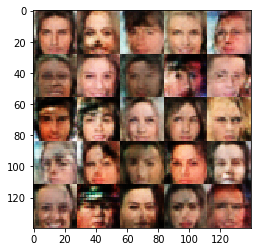

Epoch 1/1... Discriminator Loss: 1.0226... Generator Loss: 0.8105
Epoch 1/1... Discriminator Loss: 0.8869... Generator Loss: 1.3573
Epoch 1/1... Discriminator Loss: 1.6272... Generator Loss: 0.3698
Epoch 1/1... Discriminator Loss: 1.5222... Generator Loss: 0.3552
Epoch 1/1... Discriminator Loss: 1.1535... Generator Loss: 0.6643
Epoch 1/1... Discriminator Loss: 1.6316... Generator Loss: 0.3051
Epoch 1/1... Discriminator Loss: 1.6452... Generator Loss: 0.3095
Epoch 1/1... Discriminator Loss: 1.2186... Generator Loss: 0.8775
Epoch 1/1... Discriminator Loss: 1.3353... Generator Loss: 0.7615
Epoch 1/1... Discriminator Loss: 1.2077... Generator Loss: 0.7373


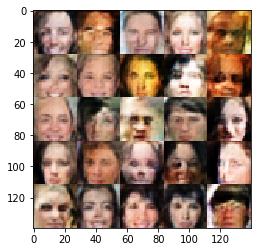

Epoch 1/1... Discriminator Loss: 1.1072... Generator Loss: 0.7864
Epoch 1/1... Discriminator Loss: 1.2312... Generator Loss: 0.6487
Epoch 1/1... Discriminator Loss: 1.1667... Generator Loss: 1.2221
Epoch 1/1... Discriminator Loss: 1.2729... Generator Loss: 0.7869
Epoch 1/1... Discriminator Loss: 1.2442... Generator Loss: 0.5582
Epoch 1/1... Discriminator Loss: 1.4922... Generator Loss: 0.4570
Epoch 1/1... Discriminator Loss: 1.0881... Generator Loss: 0.7519
Epoch 1/1... Discriminator Loss: 1.2785... Generator Loss: 0.4876
Epoch 1/1... Discriminator Loss: 1.4010... Generator Loss: 0.9220
Epoch 1/1... Discriminator Loss: 1.3581... Generator Loss: 0.5588


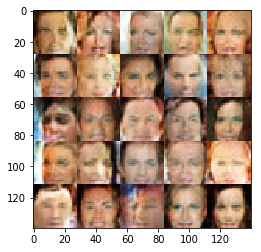

Epoch 1/1... Discriminator Loss: 1.2709... Generator Loss: 0.8250
Epoch 1/1... Discriminator Loss: 1.1628... Generator Loss: 0.7659
Epoch 1/1... Discriminator Loss: 1.2003... Generator Loss: 0.8962
Epoch 1/1... Discriminator Loss: 1.3243... Generator Loss: 1.0340
Epoch 1/1... Discriminator Loss: 1.4317... Generator Loss: 0.4945
Epoch 1/1... Discriminator Loss: 1.1714... Generator Loss: 0.6498
Epoch 1/1... Discriminator Loss: 0.9700... Generator Loss: 0.9364
Epoch 1/1... Discriminator Loss: 1.3592... Generator Loss: 0.9305
Epoch 1/1... Discriminator Loss: 1.1982... Generator Loss: 0.9978
Epoch 1/1... Discriminator Loss: 1.1958... Generator Loss: 0.7870


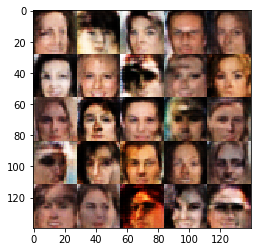

Epoch 1/1... Discriminator Loss: 1.0970... Generator Loss: 0.9579
Epoch 1/1... Discriminator Loss: 1.1690... Generator Loss: 0.5954
Epoch 1/1... Discriminator Loss: 1.1100... Generator Loss: 0.9642
Epoch 1/1... Discriminator Loss: 1.0601... Generator Loss: 0.9351
Epoch 1/1... Discriminator Loss: 1.3534... Generator Loss: 0.6696
Epoch 1/1... Discriminator Loss: 1.1392... Generator Loss: 1.0971
Epoch 1/1... Discriminator Loss: 1.2304... Generator Loss: 0.6098
Epoch 1/1... Discriminator Loss: 1.4571... Generator Loss: 0.6204
Epoch 1/1... Discriminator Loss: 1.2395... Generator Loss: 0.7652
Epoch 1/1... Discriminator Loss: 1.2677... Generator Loss: 0.5689


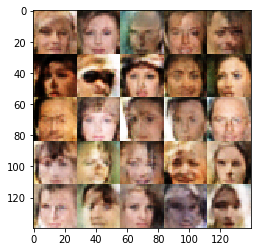

Epoch 1/1... Discriminator Loss: 1.2966... Generator Loss: 0.5195
Epoch 1/1... Discriminator Loss: 1.1096... Generator Loss: 1.3422


In [ ]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.